In [1]:
# File load

import urllib.request
from pathlib import Path
import os
import pandas as pd
import dill

# Data Manipulation
import numpy as np
from collections import Counter

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.figure import Figure
from pandas.plotting import scatter_matrix
import seaborn as sns
import scipy

# Model Building
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import cross_val_score, cross_validate
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import time
from sklearn.metrics import confusion_matrix, roc_curve, f1_score, balanced_accuracy_score, recall_score, precision_score, roc_auc_score, precision_recall_curve, auc, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc as auc

### Section 1: Loading Data

Downloading data programmatically using the Kaggle API and loading into Pandas.

In [2]:
def load_data():
    path = os.getcwd() + '/'
    pkd_file = Path(path+'creditcard.pkd')
    if pkd_file.is_file():
        data = dill.load(open(path+'creditcard.pkd', 'rb'))
    else:        
        file = 'creditcardfraud.zip'

        zip_file = Path(path + file)
        if zip_file.is_file():
            print('zip file already present')
        else:
            !kaggle datasets download -d mlg-ulb/creditcardfraud
            print ("Download complete!")

        file_raw = Path(path + 'creditcard.csv')
        if file_raw.is_file():
            print('csv file already present!')
        else:
            !unzip -u $path$file -d $path

        print('Now reading csv file')    
        data = pd.read_csv(path+'creditcard.csv',sep=',')
        dill.dump(data, open(path+'creditcard.pkd', 'wb'))
    
    return data

In [3]:
transxns = load_data()

#### 1.2: Structure of data
Number of records and fields in each record.

In [4]:
print(f'Number of Rows (Records): {transxns.shape[0]}')
print(f'Number of Columns (Fields): {transxns.shape[1]}')

Number of Rows (Records): 284807
Number of Columns (Fields): 31


+ **Data Size:** Number of Rows (Records): 786363\
Number of Columns (Fields): 29

#### 1.3: Summary Statistics

Let's look at the basic summary statistics for each field including a count of null, minimum, maximum, and unique values where appropriate.

In [5]:
transxns.head().T

,0,1,2,3,4
Time,0.000000,0.000000,1.000000,1.000000,2.000000
V1,-1.359807,1.191857,-1.358354,-0.966272,-1.158233
V2,-0.072781,0.266151,-1.340163,-0.185226,0.877737
V3,2.536347,0.166480,1.773209,1.792993,1.548718
V4,1.378155,0.448154,0.379780,-0.863291,0.403034
V5,-0.338321,0.060018,-0.503198,-0.010309,-0.407193
V6,0.462388,-0.082361,1.800499,1.247203,0.095921
V7,0.239599,-0.078803,0.791461,0.237609,0.592941
V8,0.098698,0.085102,0.247676,0.377436,-0.270533
V9,0.363787,-0.255425,-1.514654,-1.387024,0.817739


In [6]:
transxns.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
desc = transxns.describe().T
desc

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,3.918649e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,5.682686e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-8.761736e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.811118e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,-1.552103e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,2.040130e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-1.698953e-15,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,-1.893285e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-3.147640e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


### Section 2: Data Exploration & Visualizations

#### Part 2.1
Let's look at the distribution of the column `Amount` since it is the only column whose column name makes sense. Let's start with plotting the histogram.

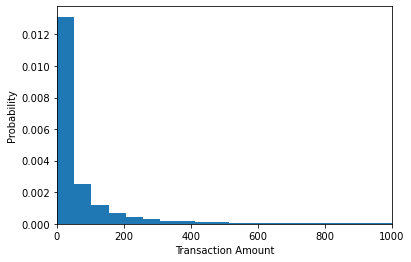

In [8]:
plt.hist(transxns['Amount'], bins = 500, density = True)
plt.xlim(0,1000)
plt.xlabel('Transaction Amount')
plt.ylabel('Probability');


+ **Insight:** The probability histogram plot above seems like an exponential curve. Let's verify that. Initially, we'll assume that the exponential index is constant and then later we'll verify the assumption.

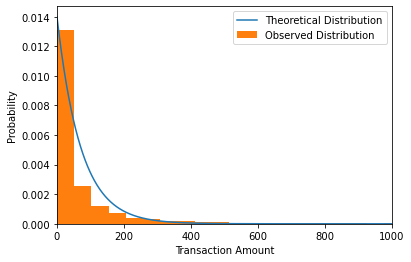

In [9]:
x = np.arange(0,2001)
c = 0.014
y = list(map(lambda a: c*np.exp(-c*a), x))
plt.plot(x,y,label='Theoretical Distribution')
plt.hist(transxns['Amount'], bins = 500, density = True, label='Observed Distribution')
plt.xlim(0,1000)
plt.xlabel('Transaction Amount')
plt.ylabel('Probability')
plt.legend();

+ **Insight:** We see a poor fit between the probabilities of transaction amounts and exponential distribution. Therefore, let's check how wrong I was by assuming that the index in the exponential term is a constant by taking the log of the distribution. If the distribution is exponential, the log of the distribution must be a straight line with a negative slope.

#### Part 2.2: Structure in Histogram

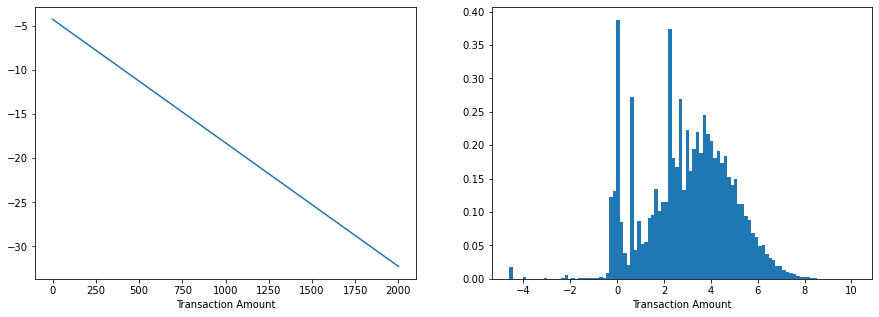

In [10]:
fig = Figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.plot(x,np.log(y))
ax.set_xlabel('Transaction Amount')
ax = fig.add_subplot(1,2,2)
ax.hist(np.log(transxns.loc[(transxns['Amount'] > 0.)]['Amount']), bins = 100, density = True)
ax.set_xlabel('Transaction Amount')
fig

+ **Insight:**
Our initial assumption is clearly wrong. The log of the distribution looks Gaussian and not a straight line. Hence the transaction amounts follows a log-normal distribution. </font> 

#### More Data Exploration:

1. Heatmap to identify collinearity between quantitative predictors.
2. Identify outliers in quantitative predictors.

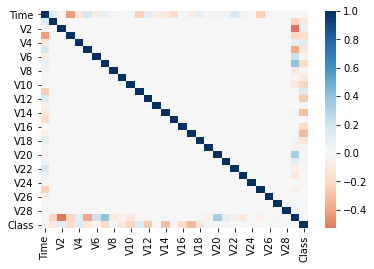

In [11]:
sns.heatmap(transxns.corr(),cmap = 'RdBu', center = 0.0);

+ **Insights:** 

1. There is little to no correlation between the predictors.
2. There is some anti-correlation between `V2` and `Amount`. Let's make a scatter plot to visualize their relation.

Pearson's r coefficient between V2 and Amount: -0.531


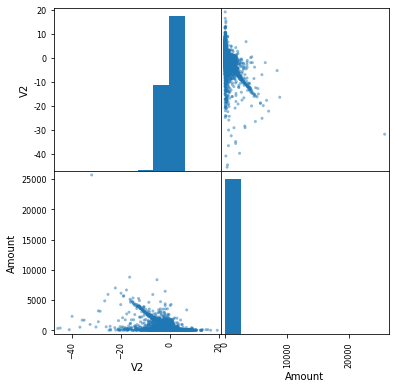

In [12]:
scatter_matrix(transxns[['V2','Amount']].sample(frac = 0.25), figsize = (6,6));
print('Pearson\'s r coefficient between V2 and Amount:',round(scipy.stats.pearsonr(transxns['V2'],transxns['Amount'])[0],3))

Mild anti-correlation (r < 0.8) between V2 and Amount. 

In [13]:
def z_score_func(df, features):
    '''
    A function that calculates the z-scores of a dataframe provided the features. The dataframe is returned wih a column named 'outliers' containing boolean values, True if an outlier is present and False if not.   
    '''
    means = np.array(df[features].mean(axis=0))   
    std_devs = np.array(df[features].std(axis=0)) 
    z_scores = (df[features] - means)/std_devs    
    outliers = abs(z_scores) > 3    
    flag = np.any(outliers,axis=1)
    df['outliers'] = flag
    
    return df

In [14]:
z_score_func(transxns,transxns.columns.drop('Class'))
outlier_pct = round(100*Counter(transxns['outliers'])[True]/transxns.shape[0],3)
print(f'Percentage of outliers = {outlier_pct}%')

Percentage of outliers = 13.278%


+ **Insight:** The number of outliers isn't small. We can check later on if removing outliers increases our model performance. For now let's just keep them.

## Section 3: Model Building

Let's draw a sample of 10% from the dataset and keep it aside as the test set.

#### Baseline Model:

Let's create a baseline model with no feature engineering and over/under sampling.

In [15]:
# Let's check the number of 
# negative or Class 0 (non fraud transactions) and 
# positive of Class 1 (fraud transactions)
labelCol = 'Class'
pct_1 = round(100*Counter(transxns[labelCol])[True]/transxns.shape[0], 2)
print('Full Data Set: \nNumber of CLass 0s (isFraud = False):', Counter(transxns[labelCol])[False])
print('Number of CLass 1s (isFraud = True):', Counter(transxns[labelCol])[True])
print(f'Percentage of 1s: {pct_1}%')

Full Data Set: 
Number of CLass 0s (isFraud = False): 284315
Number of CLass 1s (isFraud = True): 492
Percentage of 1s: 0.17%


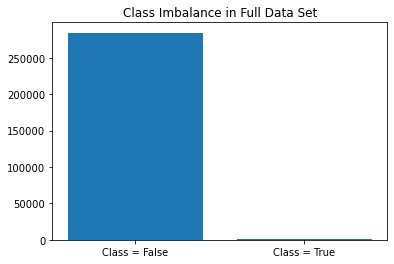

In [16]:
x = [0, 1]
height = [Counter(transxns[labelCol])[False], Counter(transxns[labelCol])[True]]
plt.bar(x, height, tick_label = ['Class = False', 'Class = True'])
plt.title('Class Imbalance in Full Data Set');

+ **Key Insight:** There is class imbalance, only 0.17% of transactions are labelled as fraud.

For the baseline model, let's draw a sample of 50,000 observations (18% of total). Once we finalize our baseline algorithm, we can train on the entire training set. 

In [17]:
randN = 1
cols = transxns.columns.drop('Class')
X_rest, X_test, y_rest, y_test = train_test_split(transxns[cols], transxns[labelCol], random_state = randN, test_size = 0.1)
X_sample, _, y_sample, _ = train_test_split(X_rest, y_rest, random_state = randN, train_size = 50000)

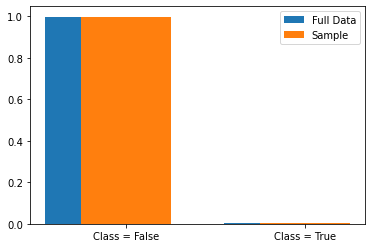

In [18]:
x = [0, 1]
height = [Counter(transxns[labelCol])[False], Counter(transxns[labelCol])[True]]
total = transxns.shape[0]
plt.bar(x, list(map(lambda x: x/transxns.shape[0], height)), tick_label = ['Class = False', 'Class = True'],width=0.5,label='Full Data')

height = [Counter(y_sample)[False], Counter(y_sample)[True]]
total = len(y_sample)
x = list(map(lambda x: x+0.2, x))
plt.bar(x, list(map(lambda x: x/total, height)), tick_label = ['Class = False', 'Class = True'],width=0.5,label='Sample')
plt.legend();

In [19]:
# Let's check the number of 
# negative or Class 0 (non fraud transactions) and 
# positive of Class 1 (fraud transactions) in the sample

pct_1 = round(100*Counter(y_sample)[True]/len(y_sample), 2)
print('Sample: \nNumber of CLass 0s (Class = False):', Counter(y_sample)[False])
print('Number of CLass 1s (Class = True):', Counter(y_sample)[True])
print(f'Percentage of 1s: {pct_1}%')

Sample: 
Number of CLass 0s (Class = False): 49896
Number of CLass 1s (Class = True): 104
Percentage of 1s: 0.21%


+ **Key Step:** Let's try out some classification models with default parameters. We also need to scale the data for models such as Logistic Regression. Let's use Maximum Absolute Scaler since it preserves the sparsity of the feature matrix.

In [20]:
def transform_func(X):
    transformer = MaxAbsScaler()
    X_transformer = transformer.fit(X)
    return X_transformer

In [29]:
estimators = {'logreg': LogisticRegression(solver = 'saga'), 
'sgd': SGDClassifier(loss='log'),               
'dtc': DecisionTreeClassifier(),               
'rfc': RandomForestClassifier(), 
'gbc': GradientBoostingClassifier(),              
'xgb': XGBClassifier(verbosity=0)            
}

In [22]:
def f2_score(true, pred):
    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    return (5 * p * r) / (4 * p + r)

def pr_auc(true, pred):
    precision, recall, thresholds = precision_recall_curve(true, pred)
    return auc(recall, precision)
    
scoring = {'recall': 'recall',
          'precision': 'precision',
          'f1': 'f1',
          'f2': make_scorer(f2_score),
          'pr_auc': make_scorer(pr_auc, needs_proba=True)
          }

In [23]:
def model_testing(X,y):
    est_scores_dict = {}

    for estimator in estimators.keys():
        est = estimators[estimator]
        print(f'Started with {est}\n')
        start = time.time()
        est_scores_dict[estimator] = cross_validate(est, X, y, scoring = scoring)
        print(f'Finished with {est}\n')
        print('Time taken = ', round((time.time() - start)/60.,2) ,'mins \n')
        
    return est_scores_dict

In [24]:
def model_score(scores_dict):
    score_set = {'test_' + score for score in scoring.keys()}
    mean_dict = {}
    std_dict = {}
    for estimator in scores_dict.keys():
        mean_dict[estimator] = {score: round(np.mean(scores_dict[estimator][score]),3) for score in score_set}
        std_dict[estimator] = {score: round(np.std(scores_dict[estimator][score]),3) for score in score_set}
    return pd.DataFrame(mean_dict), pd.DataFrame(std_dict)

In [25]:
X_sample_transformer = transform_func(X_sample)
X_sample_transform = X_sample_transformer.transform(X_sample)

In [30]:
est_scores_dict = model_testing(X_sample_transform, y_sample)

Started with LogisticRegression(solver='saga')

Finished with LogisticRegression(solver='saga')

Time taken =  0.1 mins 

Started with SGDClassifier(loss='log')

Finished with SGDClassifier(loss='log')

Time taken =  0.01 mins 

Started with DecisionTreeClassifier()

Finished with DecisionTreeClassifier()

Time taken =  0.16 mins 

Started with RandomForestClassifier()

Finished with RandomForestClassifier()

Time taken =  1.35 mins 

Started with GradientBoostingClassifier()

Finished with GradientBoostingClassifier()

Time taken =  4.8 mins 

Started with XGBClassifier(verbosity=0)

Finished with XGBClassifier(verbosity=0)

Time taken =  1.14 mins 



In [31]:
mean, std = model_score(est_scores_dict)

In [32]:
mean

,logreg,sgd,dtc,rfc,gbc,xgb
test_f2,0.599,0.448,0.755,0.835,0.754,0.826
test_precision,0.879,0.829,0.781,0.915,0.927,0.914
test_f1,0.678,0.540,0.764,0.862,0.810,0.856
test_recall,0.557,0.403,0.750,0.818,0.721,0.808
test_pr_auc,0.792,0.791,0.766,0.850,0.741,0.856


In [33]:
def performance_measure_plot(df):
    markers = ['o', 's', '+', 'x', 'D']
    it = iter(markers)
    for score in scoring:
        plt.scatter(df.columns, df.loc['test_'+score],label=score, marker=next(it))
    plt.ylabel('Performance Score')
    plt.legend(bbox_to_anchor = (1., 1.))
    plt.show();

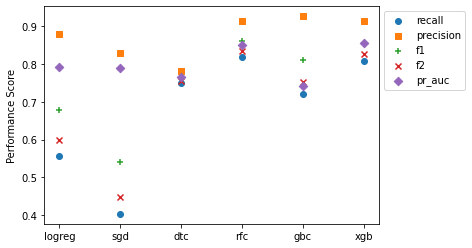

In [34]:
performance_measure_plot(mean)

+ **Key Insight:** From the performance measure plot above, the models with the best PR-AUC score are Random Forest and the XGBoost Classifier.

+ A very straightforward way to improve the baseline model would be to use over or under-sampling so that the training data contains equal number of records for both classes.  

#### Baseline Model score

In [35]:
def scores_func(clf, X, y):
    pred = clf.predict(X)
    scores = {}
    scores['recall'] = round(recall_score(y, pred), 2)
    scores['precision'] = round(precision_score(y, pred), 2)    
    scores['f1'] = round(f1_score(y, pred), 2)    
    scores['f2'] = round(f2_score(y, pred), 2)    

    prob1 = clf.predict_proba(X)[:, 1]
    scores['pr_auc'] = round(pr_auc(y, prob1), 2)   
    
    return scores

In [36]:
X_rest_transformer = transform_func(X_rest)
X_rest_transform = X_rest_transformer.transform(X_rest)

In [37]:
xgb_baseline = XGBClassifier(verbosity=0)
xgb_baseline.fit(X_rest_transform, y_rest)

XGBClassifier(verbosity=0)

In [38]:
X_test_transform = X_rest_transformer.transform(X_test)

In [39]:
xgb_baseline_scores = scores_func(xgb_baseline, X_test_transform, y_test)
xgb_baseline_scores

{'recall': 0.8, 'precision': 0.93, 'f1': 0.86, 'f2': 0.82, 'pr_auc': 0.81}

In [40]:
rfc_baseline = RandomForestClassifier()
rfc_baseline.fit(X_rest_transform, y_rest)

RandomForestClassifier()

In [41]:
rfc_baseline_scores = scores_func(rfc_baseline, X_test_transform, y_test)
rfc_baseline_scores

{'recall': 0.76, 'precision': 0.97, 'f1': 0.85, 'f2': 0.79, 'pr_auc': 0.81}

+ __Key Result:__ The best baseline model PR AUC score is 0.81

#### Under Sampling

In [42]:
rus = RandomUnderSampler(random_state = randN)
X_train, y_train = rus.fit_resample(X_rest, y_rest)

In [43]:
# Let's check the number of 
# negative or Class 0 (non fraud transactions) and 
# positive of Class 1 (fraud transactions)
labelCol = 'Class'
pct_1 = round(100*Counter(y_train)[True]/y_train.shape[0], 2)
print('Full Data Set: \nNumber of CLass 0s (isFraud = False):', Counter(y_train)[0])
print('Number of CLass 1s (isFraud = True):', Counter(y_train)[1])
print(f'Percentage of 1s: {pct_1}%')

Full Data Set: 
Number of CLass 0s (isFraud = False): 443
Number of CLass 1s (isFraud = True): 443
Percentage of 1s: 50.0%


* __Insight:__ Under sampling might not be the right approach since the number of positive samples is very low. We see above that the under-sampled training set only contains 443\*2 = 886 observations. Therefore, oversampling is preferable.  

### Over-Sampling

In [44]:
ros = RandomOverSampler(random_state = randN)
X_over_sample, y_over_sample = ros.fit_resample(X_rest, y_rest)
X_train, _, y_train, _ = train_test_split(X_over_sample,
y_over_sample, random_state = randN, train_size = 50000)

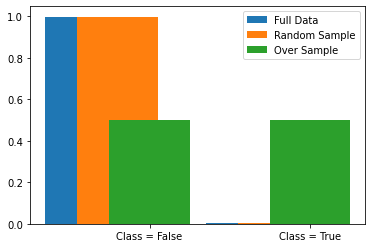

In [45]:
x = [0, 1]
height = [Counter(transxns[labelCol])[False], Counter(transxns[labelCol])[True]]
total = transxns.shape[0]
plt.bar(x, list(map(lambda x: x/transxns.shape[0], height)), tick_label = ['Class = False', 'Class = True'],width=0.5,label='Full Data')

height = [Counter(y_sample)[False], Counter(y_sample)[True]]
total = len(y_sample)
x = list(map(lambda x: x+0.2, x))
plt.bar(x, list(map(lambda x: x/total, height)), tick_label = ['Class = False', 'Class = True'],width=0.5,label='Random Sample')
plt.legend();

height = [Counter(y_train)[False], Counter(y_train)[True]]
total = len(y_train)
x = list(map(lambda x: x+0.2, x))
plt.bar(x, list(map(lambda x: x/total, height)), tick_label = ['Class = False', 'Class = True'],width=0.5,label='Over Sample')
plt.legend();

In [46]:
X_train_transformer = transform_func(X_train)
X_train_transform = X_train_transformer.transform(X_train)

In [47]:
est_scores_dict = model_testing(X_train_transform, y_train)

Started with LogisticRegression(solver='saga')

Finished with LogisticRegression(solver='saga')

Time taken =  0.08 mins 

Started with SGDClassifier(loss='log')

Finished with SGDClassifier(loss='log')

Time taken =  0.01 mins 

Started with DecisionTreeClassifier()

Finished with DecisionTreeClassifier()

Time taken =  0.07 mins 

Started with RandomForestClassifier()

Finished with RandomForestClassifier()

Time taken =  0.95 mins 

Started with GradientBoostingClassifier()

Finished with GradientBoostingClassifier()

Time taken =  2.63 mins 

Started with XGBClassifier(verbosity=0)

Finished with XGBClassifier(verbosity=0)

Time taken =  0.99 mins 



In [48]:
mean, std = model_score(est_scores_dict)

In [49]:
mean

,logreg,sgd,dtc,rfc,gbc,xgb
test_f2,0.927,0.923,0.999,1.0,0.993,0.992
test_precision,0.979,0.980,0.996,1.0,0.992,0.994
test_f1,0.946,0.943,0.998,1.0,0.992,0.993
test_recall,0.915,0.910,1.000,1.0,0.993,0.992
test_pr_auc,0.988,0.987,0.998,1.0,0.999,1.000


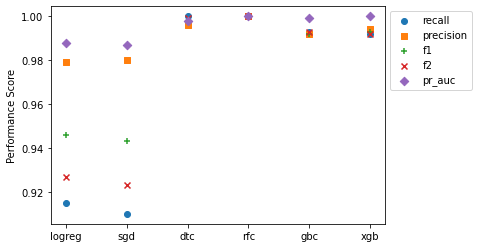

In [50]:
performance_measure_plot(mean)

+ **Key Insights:**

- Oversampling CV scores are very high (in some cases equal to 1) since many samples are present in both the training and the validation set.
- The best model seems to be the Random Forest Classifier & XGBoost Classifier with the highest PR AUC & Recall. 

Let's short-list both Random Forest Classifier and XGBoost Classifier for the next stage.

### Model Fine-tuning

Now let's fine tune the hyper-parameters of the short-listed models using Grid Search Cross-Validation. We must specify the scoring metric. For fraud detection, we care more about the under-represented class or fraud transactions. If a fraud transaction goes through, the customer loses money. Therefore, metrics such as _Recall_ and _PR AUC_ are suitable. 

#### Random Forest Classifier

In [51]:
param_grid = {'max_depth': [5, 10],
             'n_estimators': [100, 200],
             'max_features': [0.25, 0.5]} 

In [52]:
rfc = RandomForestClassifier()

In [53]:
grid_search = GridSearchCV(rfc, param_grid, cv = 5, scoring = scoring['pr_auc'])

In [54]:
start = time.time()
grid_search.fit(X_train_transform, y_train)
print('Random Forest Classifier Grid Search Time Taken: ', round( (time.time() - start)/60., 3), ' mins')

Random Forest Classifier Grid Search Time Taken:  17.58  mins


In [55]:
rfc_best_est = grid_search.best_estimator_
rfc_best_est 

RandomForestClassifier(max_depth=10, max_features=0.25, n_estimators=200)

In [56]:
X_over_sample_transformer = transform_func(X_over_sample)
X_over_sample_transform = X_over_sample_transformer.transform(X_over_sample)

In [57]:
rfc_best_est.fit(X_over_sample_transform, y_over_sample)

RandomForestClassifier(max_depth=10, max_features=0.25, n_estimators=200)

In [58]:
def plot_scores(scores):
    x = list(scores.keys())
    y = [scores[i] for i in x]
    plt.scatter(x, y)
    plt.xlabel('Metric')
    plt.ylabel('Scores')
    plt.title('Test Scores')

In [59]:
X_test_transform = X_over_sample_transformer.transform(X_test)

In [60]:
test_scores = scores_func(rfc_best_est, X_test_transform, y_test)
test_scores

{'recall': 0.82, 'precision': 0.68, 'f1': 0.74, 'f2': 0.78, 'pr_auc': 0.78}

In [61]:
def compare_train_test(train_scores, test_scores):
    test_recall, train_recall = test_scores['recall'], train_scores['recall']
    test_pr_auc, train_pr_auc = test_scores['pr_auc'], train_scores['pr_auc']
    print(f'Recall scores: Test {test_recall} vs Train {train_recall}')
    print(f'PR Auc scores: Test {test_pr_auc} vs Train {train_pr_auc}')

In [62]:
train_scores = scores_func(rfc_best_est, X_over_sample_transform, y_over_sample)
compare_train_test(train_scores, test_scores)

Recall scores: Test 0.82 vs Train 0.99
PR Auc scores: Test 0.78 vs Train 1.0


+ **Comment**: We notice that the difference between training and test scores is large. Also, the training scores are near perfect, 1.0. Therefore, the Random Forest model overfits!

In [63]:
rfc_val_scores = cross_validate(rfc_best_est, X_over_sample_transform, y_over_sample, scoring = scoring, return_train_score=True)

In [64]:
print('Train scores (PR):', round(np.mean(rfc_val_scores['train_pr_auc']),3), '+\-', round(np.std(rfc_val_scores['train_pr_auc']),3))
print('Validation scores (PR):', round(np.mean(rfc_val_scores['test_pr_auc']),3), '+\-', round(np.std(rfc_val_scores['test_pr_auc']),3))

Train scores (PR): 1.0 +\- 0.0
Validation scores (PR): 1.0 +\- 0.0


#### XGBoost Classifier

In [65]:
param_grid = {'max_depth': [5, 10, 20],
             'lambda': [1, 5, 10],
             'eta': [0.03, 0.3, 1.]
             } 

In [66]:
xgb = XGBClassifier(verbosity=0)

In [67]:
grid_search = GridSearchCV(xgb, param_grid, cv = 5, scoring = scoring['pr_auc'])

In [68]:
start = time.time()
grid_search.fit(X_train_transform, y_train);
print('XGBoost Grid Search Time Taken: ', round( (time.time() - start)/60., 3), ' mins')

XGBoost Grid Search Time Taken:  57.267  mins


In [70]:
xgb_best_est = grid_search.best_estimator_
xgb_best_est

XGBClassifier(eta=0.03, lambda=1, max_depth=5, verbosity=0)

In [71]:
xgb_best_est.fit(X_over_sample_transform, y_over_sample);

In [72]:
test_scores = scores_func(xgb_best_est, X_test_transform, y_test)
test_scores

{'recall': 0.82, 'precision': 0.63, 'f1': 0.71, 'f2': 0.77, 'pr_auc': 0.82}

In [73]:
train_scores = scores_func(xgb_best_est, X_train_transform, y_train)
compare_train_test(train_scores, test_scores)

Recall scores: Test 0.82 vs Train 0.9
PR Auc scores: Test 0.82 vs Train 1.0


+ **Insight:**  We notice that the PR AUC score is 0.62 for both SGD & XGB Classifiers. Therefore, undersampling did not work. Let's go back to the original unbalanced sample.

#### More Insights from Logistic Regression

##### Confusion Matrix: 
Let's look at the number of true positives, true negatives, false positives and false negatives from the test set. We'll see that there were only 369 fraud transactions which were prdicted as normal. This means our model has correctly given more importance to false negatives.

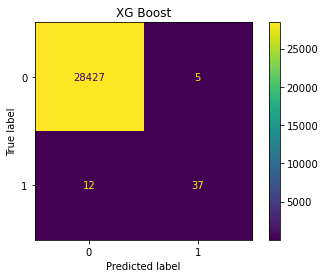

In [241]:
disp = plot_confusion_matrix(xgb_unbal_best_est, X_test_transform, y_test)
disp.ax_.set_title('XG Boost');

##### ROC Curve

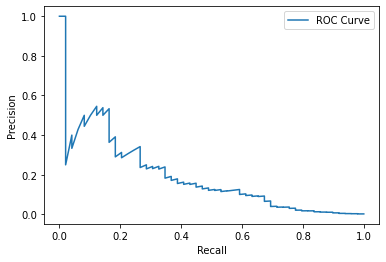

In [245]:
prob1 = [prob[1] for prob in xgb_unbal_best_est.predict_proba(X_test)]
precision, recall, thresholds = precision_recall_curve(y_test, prob1)
plt.plot(recall,precision, label='ROC Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend();

##### Feature Importance

What were some of the most important features determining fraud transactions? 

In [97]:
import xgboost

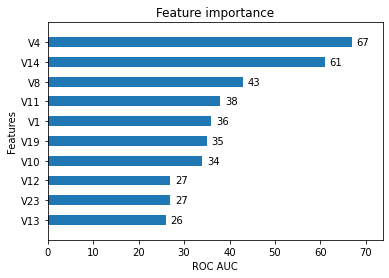

In [106]:
xgboost.plot_importance(xgb_best_est,height = 0.5, grid=False, max_num_features=10,xlabel='ROC AUC');

+ **Key Insight:** `transactionAmount` is the most important factor determining fraud transactions. `merchantCategoryCode` is also a very important factor.  

#### Summary of Question 4: Model
<font color = 'blue'>
    
1. Converted categorical columns to numerical values using one hot encoding.
    
2. Coverted dat/time strings to month, day and hour.
    
3. Did feature engineering such as checking if `acqCountry` is different than `merchantCountryCode`, etc.
    
4. Created a baseline model by trying out many models with default hyper-parameter values. The baseline model performs poorly because the fraction of fraud transactions in the data set is very small.
    
5. Undersampling: Created a new training set with equal number of fraud and normal transactions. The models perform much better now. Shortlisted Random Forest Classifier and Logistic Regression.
    
6. Fine-tuning: Used grid search cross-validation method and roc_auc scores to fine-tune the short-listed models. The test/generalization score of Random Forest is worse as compared to Logistic Regression since Random Forest overfits the training data.
    
7. Chose Logistic Regression as the final model. The ROC AUC score was 0.75 on the test set. 
    
8. Also deduced feature importance. Concluded that `transactionAmount` and `merchantCategoryCode` are the two most important features. </font>

#### What I would do next with more time?
<font color = 'blue'>
    
1. Missing Values/ Empty Strings: Currently in our model missing values are considered to be a seperate category. It would be worthwhile to check if the scores imrpove if we impute the missing values.

2. Outliers: Checking if dropping outliers would help.

3. Feature Engineering: More advanced features can be created such as identifying anomolous transaction amount, unusual time/day of the week of the transaction for each account number, identifying holidays and weekends where purchasing rates are usually higher. 

4. Code documentation: Adding doc strings to functions.</font>